# Data Exploration

In [2]:
import pandas as pd


train = pd.read_csv("data/train.csv")
train_shape = train.shape

test = pd.read_csv("data/test.csv")
test_shape = test.shape

print(test_shape, train_shape)

(418, 11) (891, 12)


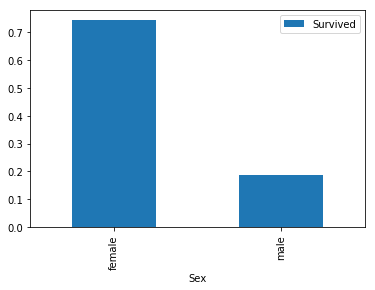

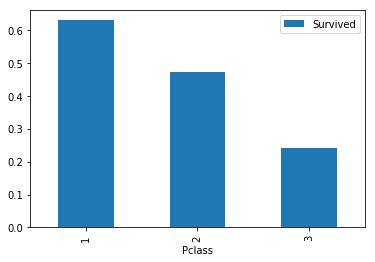

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

train_pivot = train.pivot_table(index="Pclass", values="Survived")
train_pivot.plot.bar()
plt.show()

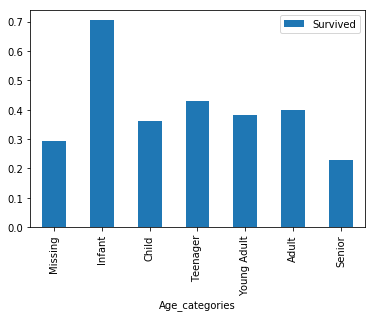

In [5]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant", "Child","Teenager","Young Adult", "Adult", "Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

table_pivot = train.pivot_table(index='Age_categories',values="Survived")
table_pivot.plot.bar()
plt.show()

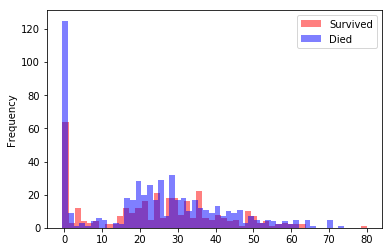

In [6]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges. We can use the pandas.cut() function to help us out.

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don't imply any numeric relationship where there isn't one. If we think of the values in the `Pclass` column, we know they are 1, 2, and 3.

In [7]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


In [9]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

train_X, test_X, train_y, test_y = train_test_split(
    train[columns], train['Survived'], test_size=0.2,random_state=0)
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)

In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)
accuracy = np.mean(scores)

print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


In [26]:

holdout_ids = holdout["PassengerId"]

lr = LogisticRegression().fit(train[columns], train['Survived'])
holdout_predictions = lr.predict(holdout[columns])
submission = pd.DataFrame({"PassengerId": holdout_ids, "Survived": holdout_predictions})
submission.to_csv("submission_1.csv", index=False)


# Feature Selection
helps to exclude features which are not good predictors, or features that are closely related to each other.

In [27]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype='object')


In [28]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train['Embarked'] = train['Embarked'].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,'Embarked')
holdout = create_dummies(holdout,"Embarked")    
                         
columns = ["SibSp","Parch","Fare"]
                         
for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


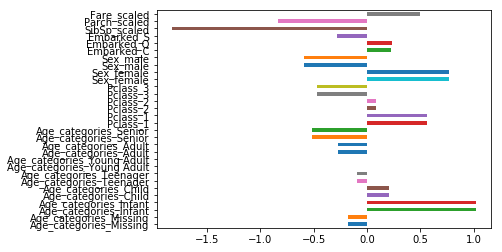

In [29]:

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression().fit(train[columns], train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train[columns].columns)

feature_importance.plot.barh()

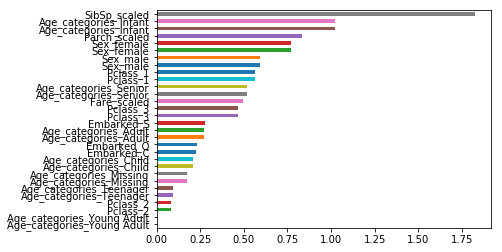

In [30]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()